In [38]:
import util
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [39]:
y, train, val, test = util.get_labels_and_split_augmented() # Can use anything here

y_train, y_val, y_test = y[train], y[val], y[test]

y_keep = y_train

y_train = tf.one_hot(y_train, depth=8)
y_val   = tf.one_hot(y_val,   depth=8)
y_test  = tf.one_hot(y_test,  depth=8)

low_res = util.get_low_res_augmented() # Match abvoe
# low_res = np.load('low_res.npy')

# low_res.reshape(low_res.shape[0], -1)

X_train = low_res[train]
X_val = low_res[val]
X_test = low_res[test]

7301it [00:09, 779.25it/s] 


In [40]:
edge_count_train = []

for i in tqdm(range(X_train.shape[0])):
    gray_image = cv2.cvtColor(X_train[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_train.append(edges.sum())

edge_count_train = np.array(edge_count_train)

edge_count_val = []

for i in tqdm(range(X_val.shape[0])):
    gray_image = cv2.cvtColor(X_val[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_val.append(edges.sum())

edge_count_val = np.array(edge_count_val)

edge_count_test = []

for i in tqdm(range(X_test.shape[0])):
    gray_image = cv2.cvtColor(X_test[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_test.append(edges.sum())

edge_count_test = np.array(edge_count_test)

100%|██████████| 704/704 [00:00<00:00, 5571.11it/s]


In [41]:

X_train_edge = X_train[edge_count_train > 800000]
y_train_edge = y_train[edge_count_train > 800000]
X_val_edge = X_val[edge_count_val > 800000]
y_val_edge = y_val[edge_count_val > 800000]
X_test_edge = X_test[edge_count_test > 800000]
y_test_edge = y_test[edge_count_test > 800000]

In [42]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(147, 147, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
history = model.fit(X_train_edge, y_train_edge, validation_data=(X_val_edge, y_val_edge), epochs=10, batch_size=32)

Epoch 1/10
81/81 [==============================] - 105s 1s/step - loss: 1.1568 - accuracy: 0.6136 - val_loss: 1.2002 - val_accuracy: 0.5928
Epoch 2/10
81/81 [==============================] - 112s 1s/step - loss: 1.1112 - accuracy: 0.6249 - val_loss: 1.2059 - val_accuracy: 0.5831
Epoch 3/10
81/81 [==============================] - 111s 1s/step - loss: 1.0514 - accuracy: 0.6323 - val_loss: 1.2213 - val_accuracy: 0.6059
Epoch 4/10
81/81 [==============================] - 117s 1s/step - loss: 1.0091 - accuracy: 0.6432 - val_loss: 1.1989 - val_accuracy: 0.5928
Epoch 5/10
81/81 [==============================] - 113s 1s/step - loss: 0.9708 - accuracy: 0.6647 - val_loss: 1.1879 - val_accuracy: 0.5961
Epoch 6/10
81/81 [==============================] - 119s 1s/step - loss: 0.9520 - accuracy: 0.6659 - val_loss: 1.2383 - val_accuracy: 0.6026
Epoch 7/10
81/81 [==============================] - 120s 1s/step - loss: 0.9347 - accuracy: 0.6682 - val_loss: 1.2405 - val_accuracy: 0.5928
Epoch 8/10
81

In [60]:

val_loss_edge, val_accuracy_edge = model.evaluate(X_val_edge, y_val_edge)

10/10 [==============================] - 12s 1s/step - loss: 1.2488 - accuracy: 0.5896


In [61]:
edge_acc = np.array(y_val[edge_count_val < 800000] == 1).mean() * 8
small = y_val[edge_count_val < 800000].shape[0]
big = y_val[edge_count_val >= 800000].shape[0]
val_accuracy = val_accuracy_edge * big / (small + big) + edge_acc * small / (small + big)

print("val acc: " + str(val_accuracy))

val acc: 0.6735751256732743


In [62]:
y_train[edge_count_train < 800000]

<tf.Tensor: shape=(551, 8), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)>

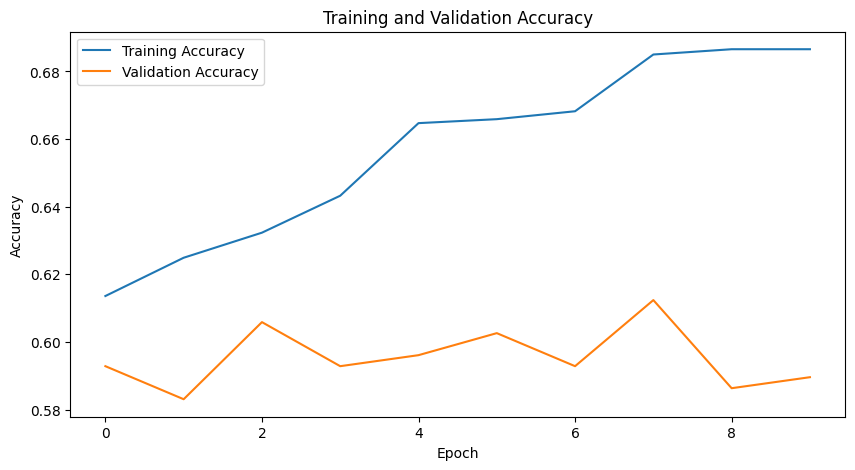

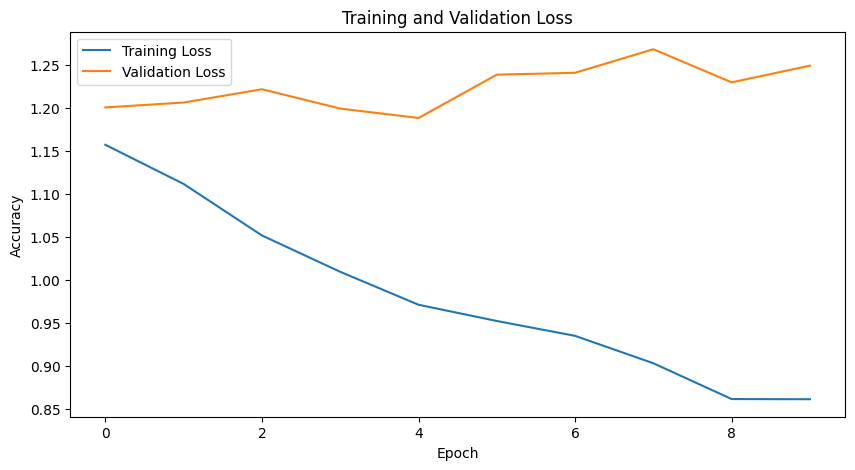

In [65]:

# test_loss, test_accuracy = cnn.evaluate(X_test, y_test)

# print("test acc: " + str(test_accuracy))


training_acc = history.history["accuracy"]
training_loss = history.history["loss"]
validation_acc = history.history["val_accuracy"]
validation_loss = history.history["val_loss"]

plt.figure(figsize=(10,5))
plt.plot(training_acc, label="Training Accuracy")
plt.plot(validation_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



In [66]:
y, train, val, test = util.get_labels_and_split()

y_train, y_val, y_test = y[train], y[val], y[test]

y_train = tf.one_hot(y_train, depth=8)
y_val   = tf.one_hot(y_val,   depth=8)
y_test  = tf.one_hot(y_test,  depth=8)

low_res = util.get_low_res()
# low_res = np.load('low_res.npy')

# low_res.reshape(low_res.shape[0], -1)

X_train = low_res[train]
X_val = low_res[val]
X_test = low_res[test]

edge_count_train = []

for i in tqdm(range(X_train.shape[0])):
    gray_image = cv2.cvtColor(X_train[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_train.append(edges.sum())

edge_count_train = np.array(edge_count_train)

edge_count_val = []

for i in tqdm(range(X_val.shape[0])):
    gray_image = cv2.cvtColor(X_val[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_val.append(edges.sum())

edge_count_val = np.array(edge_count_val)

edge_count_test = []

for i in tqdm(range(X_test.shape[0])):
    gray_image = cv2.cvtColor(X_test[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_test.append(edges.sum())

edge_count_test = np.array(edge_count_test)

X_train_edge = X_train[edge_count_train > 800000]
y_train_edge = y_train[edge_count_train > 800000]
X_val_edge = X_val[edge_count_val > 800000]
y_val_edge = y_val[edge_count_val > 800000]
X_test_edge = X_test[edge_count_test > 800000]
y_test_edge = y_test[edge_count_test > 800000]

3889it [00:04, 818.38it/s]
100%|██████████| 390/390 [00:00<00:00, 6297.92it/s]


In [67]:
val_loss_edge, val_accuracy_edge = model.evaluate(X_val_edge, y_val_edge)

edge_acc = np.array(y_val[edge_count_val < 800000] == 1).mean() * 8
small = y_val[edge_count_val < 800000].shape[0]
big = y_val[edge_count_val >= 800000].shape[0]
val_accuracy = val_accuracy_edge * big / (small + big) + edge_acc * small / (small + big)

print("unaugmented val acc: " + str(val_accuracy))

test_loss_edge, test_accuracy_edge = model.evaluate(X_test_edge, y_test_edge)

edge_acc = np.array(y_test[edge_count_test < 800000] == 1).mean() * 8
small = y_test[edge_count_test < 800000].shape[0]
big = y_test[edge_count_test >= 800000].shape[0]
test_accuracy = test_accuracy_edge * big / (small + big) + edge_acc * small / (small + big)

print("unaugmented test acc: " + str(test_accuracy))

10/10 [==============================] - 12s 1s/step - loss: 1.2488 - accuracy: 0.5896
unaugmented val acc: 0.6735751256732743
10/10 [==============================] - 11s 1s/step - loss: 1.3649 - accuracy: 0.6026
unaugmented test acc: 0.6871794998645783


In [79]:
preds = model.predict(X_test_edge)
preds

10/10 [==============================] - 15s 2s/step


array([[5.66033609e-02, 1.80085897e-01, 2.26215601e-01, ...,
        1.50607657e-02, 2.39553347e-01, 1.91718582e-02],
       [5.16821980e-04, 5.86051464e-01, 7.26784617e-02, ...,
        4.80507500e-02, 4.68625128e-02, 3.44267339e-02],
       [3.67587672e-05, 9.88133013e-01, 4.00170358e-03, ...,
        9.93588583e-06, 3.37718171e-04, 6.60266075e-03],
       ...,
       [1.51978736e-03, 6.55535579e-01, 7.05882832e-02, ...,
        3.40654445e-03, 9.52286646e-03, 6.19269088e-02],
       [7.61729619e-03, 5.53469241e-01, 2.24195987e-01, ...,
        3.15932222e-02, 3.31272259e-02, 5.69393672e-02],
       [6.34732305e-06, 9.95417953e-01, 2.70367623e-03, ...,
        3.24407870e-06, 1.09728135e-04, 1.02765462e-03]], dtype=float32)

In [91]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
roc_auc_score(y_test_edge, preds)

0.7502318658988141

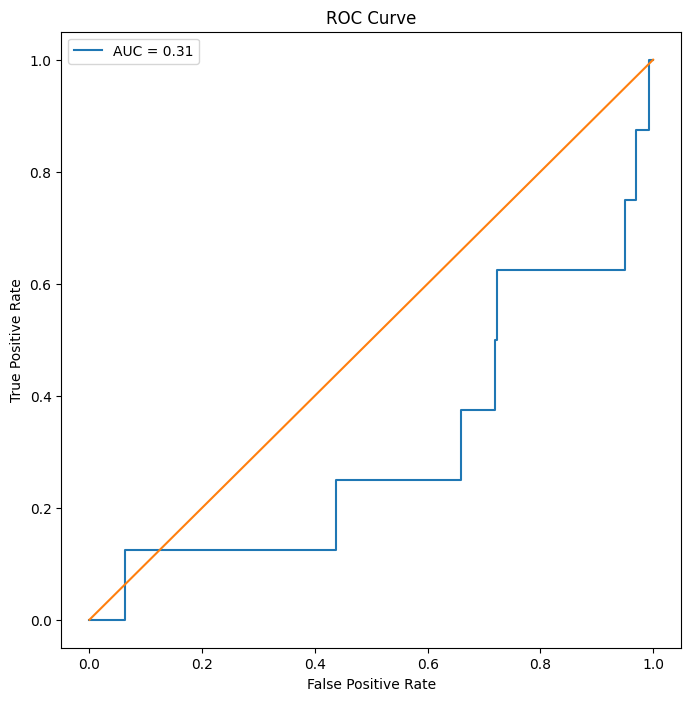

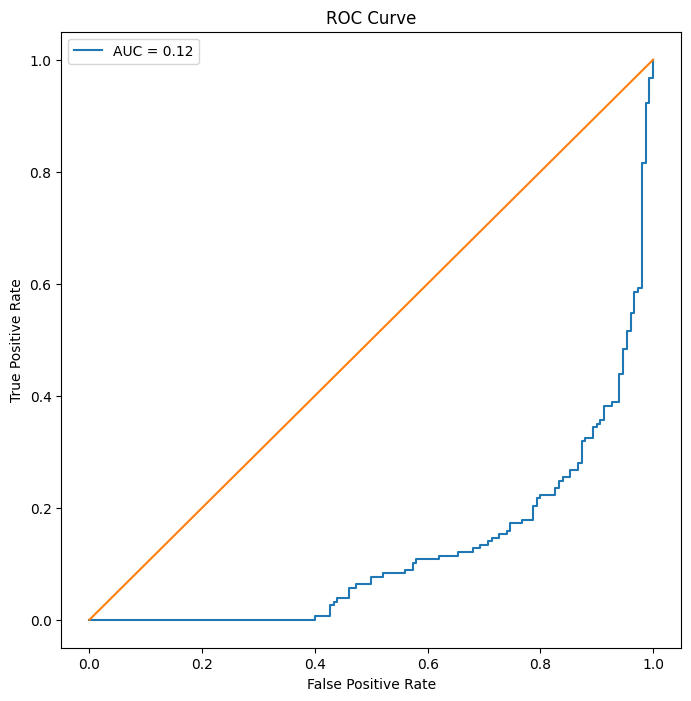

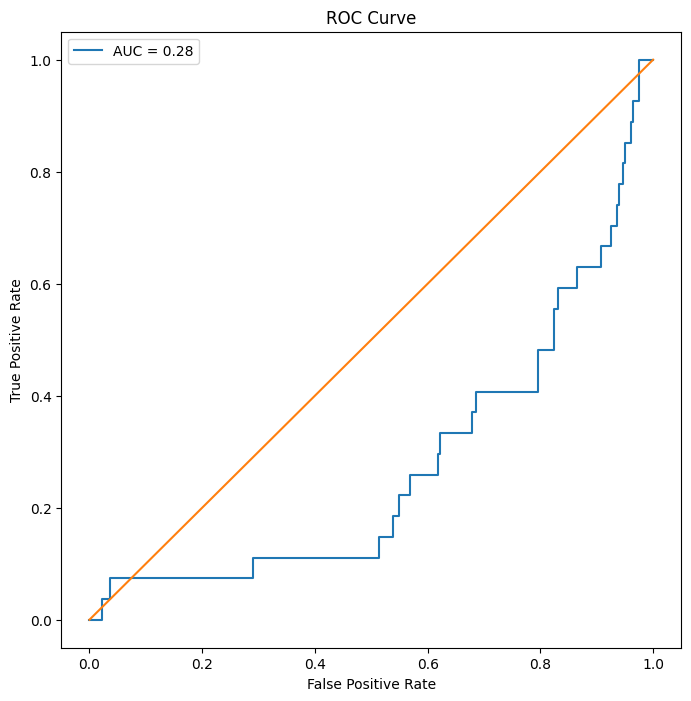

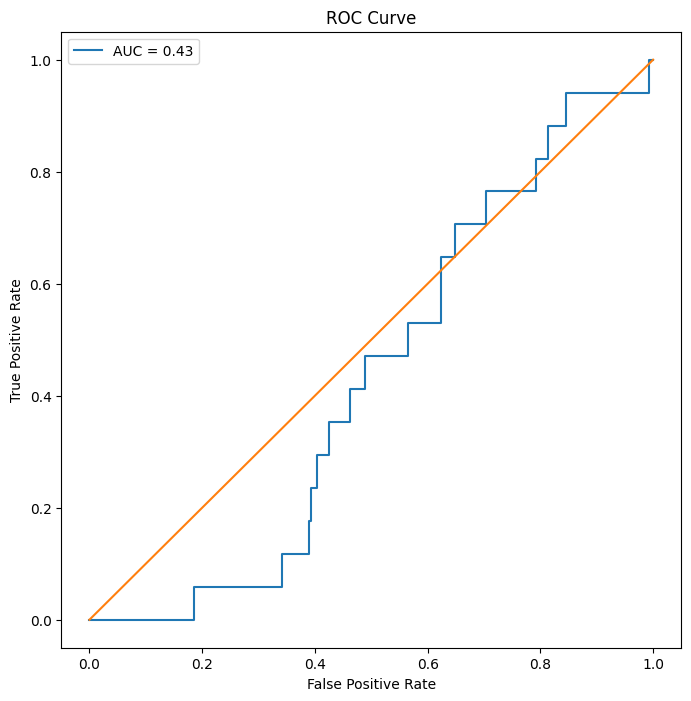

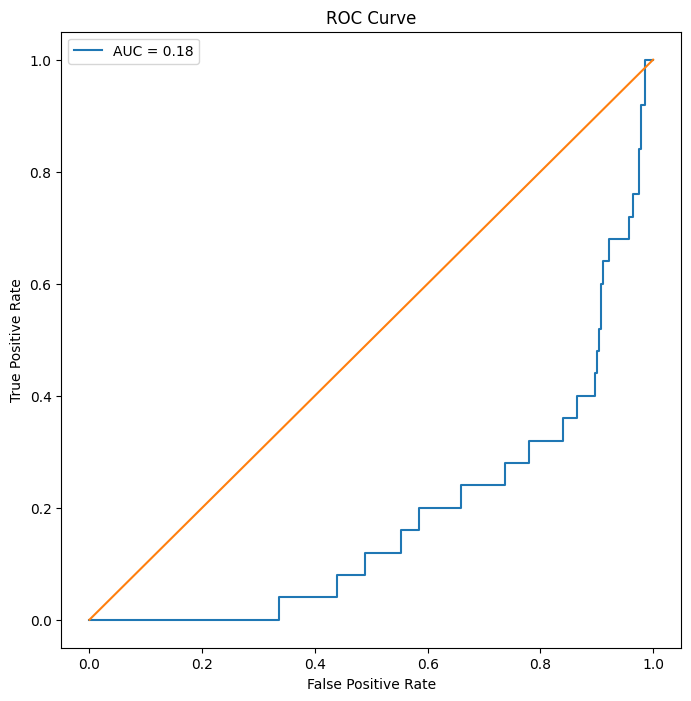

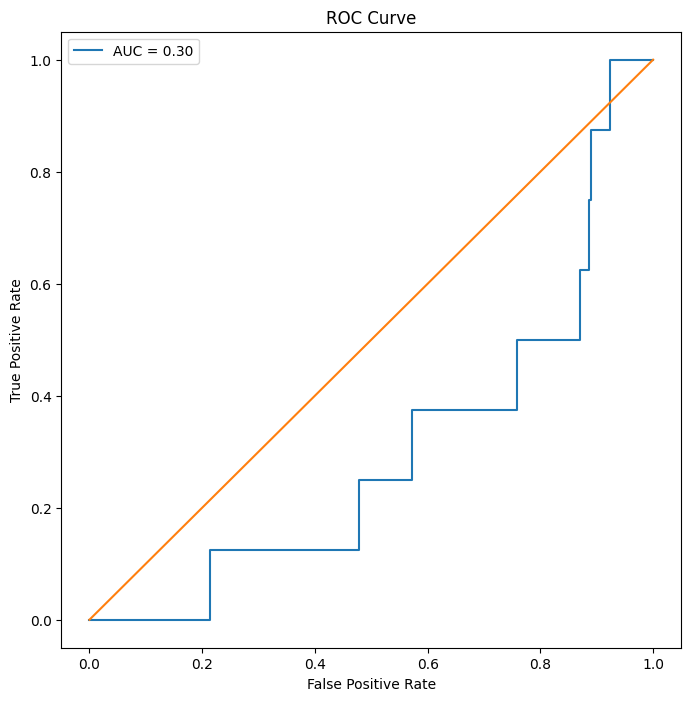

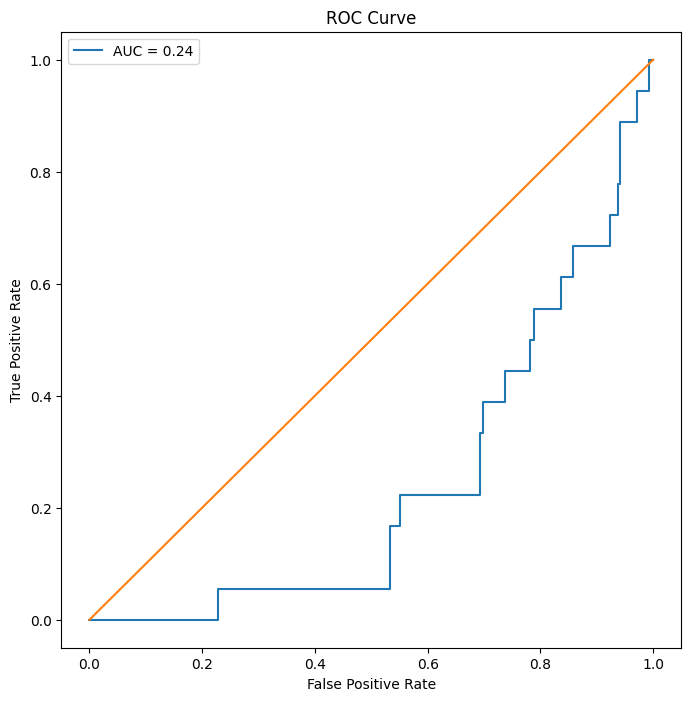

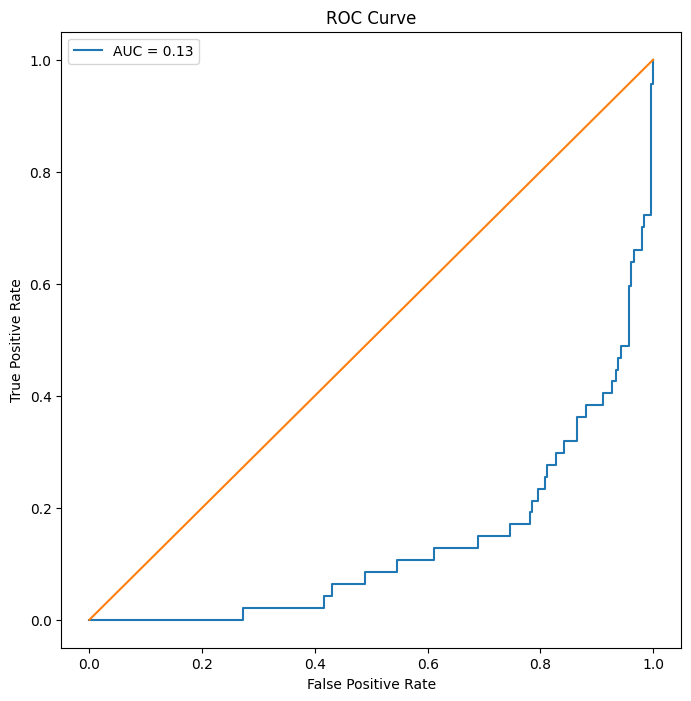

In [103]:
for i in range(8):
    mask = np.ones(8, dtype=bool)
    mask[i] = False

    all_but = np.sum(preds[:, mask], axis=1)

    fpr, tpr, thresholds = roc_curve(np.array(y_test_edge).argmax(axis=1) == i, all_but)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1],)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


In [80]:
preds.shape

(307, 8)

In [74]:
model.save("Final_Model.h5")

In [ ]:
preds.argmax(axis=1) != np.array(y_test_edge).argmax(axis=1)

In [ ]:
edge_count_test > 800000

In [102]:
test

Amnesty POI-10-1-1    False
Amnesty POI-10-1-2    False
Amnesty POI-10-1-3    False
Amnesty POI-10-2-1     True
Amnesty POI-10-2-2    False
                      ...  
UNHCR-UGAs990098      False
UNHCR-NERs009690      False
UNHCR-LBNs029606      False
UNHCR-PAKs003486      False
UNHCR-SSDs008817      False
Name: split, Length: 3889, dtype: bool

In [106]:
Final_Predictions = np.ones(test[test].shape)

In [109]:
Final_Predictions[edge_count_test > 800000] = preds.argmax(axis=1)

In [116]:
Real_Labels = np.array(y_test).argmax(axis=1)

In [117]:
Final_Predictions == Real_Labels

array([ True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False,  True, False,
        True, False, False,  True, False, False,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True, False,
       False,  True, False, False,  True,  True, False, False,  True,
       False, False, False, False,  True,  True, False,  True, False,
       False,  True,

In [119]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

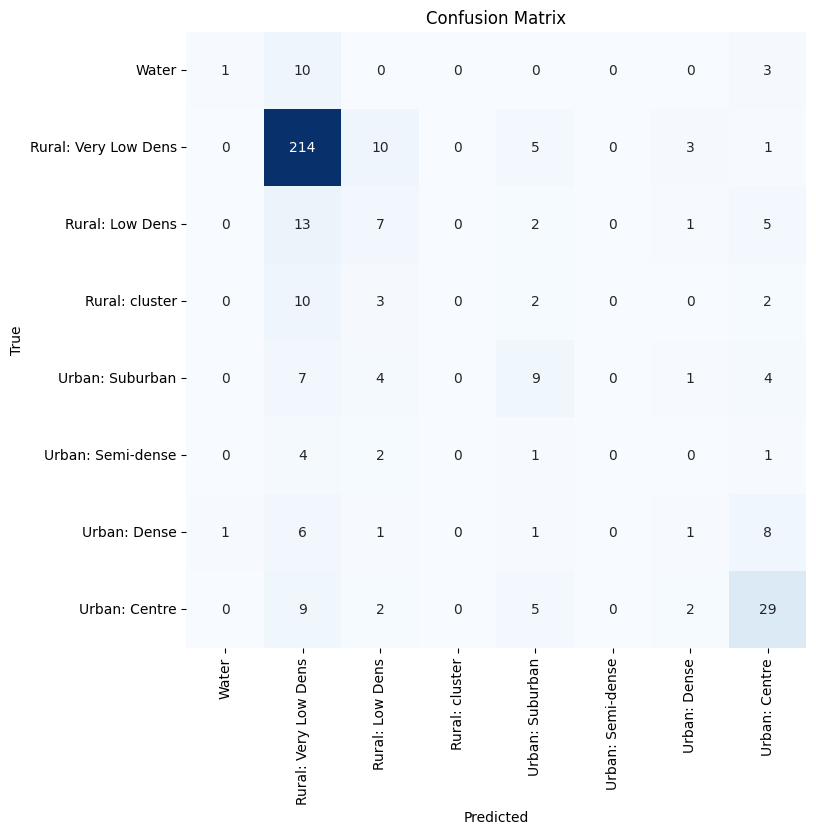

In [121]:
cm = confusion_matrix(Real_Labels, Final_Predictions, labels=np.arange(8))
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Water", "Rural: Very Low Dens", "Rural: Low Dens", "Rural: cluster", "Urban: Suburban", "Urban: Semi-dense", "Urban: Dense", "Urban: Centre"],
            yticklabels=["Water", "Rural: Very Low Dens", "Rural: Low Dens", "Rural: cluster", "Urban: Suburban", "Urban: Semi-dense", "Urban: Dense", "Urban: Centre"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [130]:
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [129]:
precision, recall, f1, _ = precision_recall_fscore_support(Real_Labels, Final_Predictions, labels=np.arange(8), average=None)
for i in range(8):
    print(f'Class {i}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1 Score={f1[i]:.2f}')

Class 0: Precision=0.50, Recall=0.07, F1 Score=0.12
Class 1: Precision=0.78, Recall=0.92, F1 Score=0.85
Class 2: Precision=0.24, Recall=0.25, F1 Score=0.25
Class 3: Precision=0.00, Recall=0.00, F1 Score=0.00
Class 4: Precision=0.36, Recall=0.36, F1 Score=0.36
Class 5: Precision=0.00, Recall=0.00, F1 Score=0.00
Class 6: Precision=0.12, Recall=0.06, F1 Score=0.08
Class 7: Precision=0.55, Recall=0.62, F1 Score=0.58


/Users/jackhlavka/miniconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
f1_score(Real_Labels, Final_Predictions, average='weighted')

0.6239866982554889

In [133]:
print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
for i in range(8):
    print(f"Class {i:<10} {precision[i]:<10.2f} {recall[i]:<10.2f} {f1[i]:<10.2f}")


Class      Precision  Recall     F1 Score  
Class 0          0.50       0.07       0.12      
Class 1          0.78       0.92       0.85      
Class 2          0.24       0.25       0.25      
Class 3          0.00       0.00       0.00      
Class 4          0.36       0.36       0.36      
Class 5          0.00       0.00       0.00      
Class 6          0.12       0.06       0.08      
Class 7          0.55       0.62       0.58      
